# Paper Review Benchmark Analysis

This notebook visualizes the benchmark results comparing different LLM models for automated paper review.

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Load Benchmark Results

In [2]:
# Find results directory
results_dir = Path("../data_50/benchmark_results")

# Load all result files
results = {}
for results_file in results_dir.glob("results_*.json"):
    config_name = results_file.stem.replace("results_", "")
    with open(results_file) as f:
        results[config_name] = json.load(f)

print(f"Loaded {len(results)} benchmark configurations:")
for name in sorted(results.keys()):
    n_papers = len(results[name].get("paper_results", []))
    model = results[name].get("config", {}).get("model", "unknown")
    print(f"  - {name}: {n_papers} papers ({model})")

Loaded 5 benchmark configurations:
  - claude-opus: 50 papers (anthropic:claude-opus-4-6)
  - gpt-5.2: 50 papers (openai:gpt-5.2)
  - gpt-5.2-reflection: 50 papers (openai:gpt-5.2)
  - grok-non-reasoning: 50 papers (xai:grok-4-1-fast-non-reasoning)
  - grok-reasoning: 50 papers (xai:grok-4-1-fast-reasoning)


## Build DataFrames

In [3]:
# Build a unified dataframe with all paper results
rows = []
for config_name, data in results.items():
    config = data.get("config", {})
    for paper in data.get("paper_results", []):
        if paper.get("error") is None:  # Skip failed reviews
            rows.append({
                "config": config_name,
                "model": config.get("model", "unknown"),
                "reflections": config.get("num_reflections", 0),
                "paper_id": paper["paper_id"],
                "conference": paper["conference"],
                "year": paper["year"],
                "sample_category": paper["sample_category"],
                "real_score": paper["real_average_score"],
                "generated_score": paper["generated_overall"],
                "real_decision": paper["real_decision"],
                "generated_decision": paper["generated_decision"],
                "real_tier": paper["real_presentation_tier"],
            })

df = pd.DataFrame(rows)
print(f"Total paper reviews: {len(df)}")
df.head()

Total paper reviews: 243


,config,model,reflections,paper_id,conference,year,sample_category,real_score,generated_score,real_decision,generated_decision,real_tier
0,grok-reasoning,xai:grok-4-1-fast-reasoning,0,mkDam1xIzW,ICLR,2025,random,7.333333,8.0,Accept (Spotlight),Accept,spotlight
1,grok-reasoning,xai:grok-4-1-fast-reasoning,0,0FK6tzqV76,ICLR,2025,random,5.750000,8.0,Accept (Poster),Accept,poster
2,grok-reasoning,xai:grok-4-1-fast-reasoning,0,krx55l2A6G,ICLR,2024,random,6.200000,9.0,Accept (poster),Accept,poster
3,grok-reasoning,xai:grok-4-1-fast-reasoning,0,ziDFH8TPPK,ICLR,2024,random,6.250000,9.0,Accept (spotlight),Accept,spotlight
4,grok-reasoning,xai:grok-4-1-fast-reasoning,0,eE2PXlNydB,ICLR,2025,random,6.000000,8.0,Accept (Poster),Accept,poster


## Score Distribution Histograms

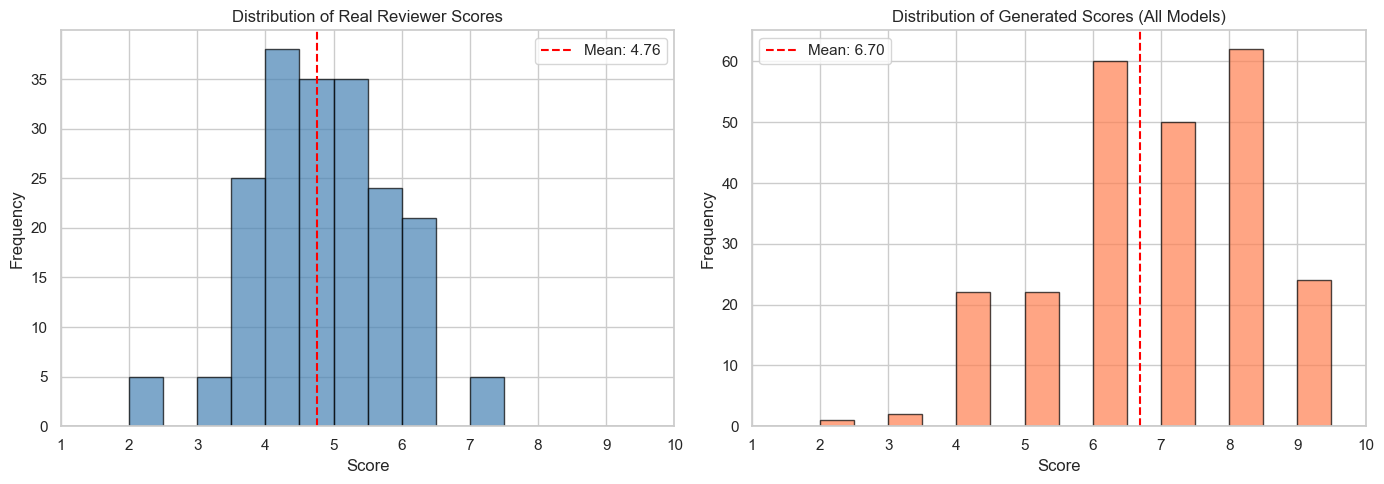

In [4]:
# Real vs Generated score distributions (all models combined)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Real scores distribution
ax1 = axes[0]
real_scores = df[df["real_score"] > 0]["real_score"]  # Filter out ICML papers with no scores
ax1.hist(real_scores, bins=np.arange(1, 11, 0.5), edgecolor="black", alpha=0.7, color="steelblue")
ax1.axvline(real_scores.mean(), color="red", linestyle="--", label=f"Mean: {real_scores.mean():.2f}")
ax1.set_xlabel("Score")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Real Reviewer Scores")
ax1.legend()
ax1.set_xlim(1, 10)

# Generated scores distribution
ax2 = axes[1]
gen_scores = df[df["generated_score"] > 0]["generated_score"]
ax2.hist(gen_scores, bins=np.arange(1, 11, 0.5), edgecolor="black", alpha=0.7, color="coral")
ax2.axvline(gen_scores.mean(), color="red", linestyle="--", label=f"Mean: {gen_scores.mean():.2f}")
ax2.set_xlabel("Score")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of Generated Scores (All Models)")
ax2.legend()
ax2.set_xlim(1, 10)

plt.tight_layout()
plt.savefig("../data_50/benchmark_results/score_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

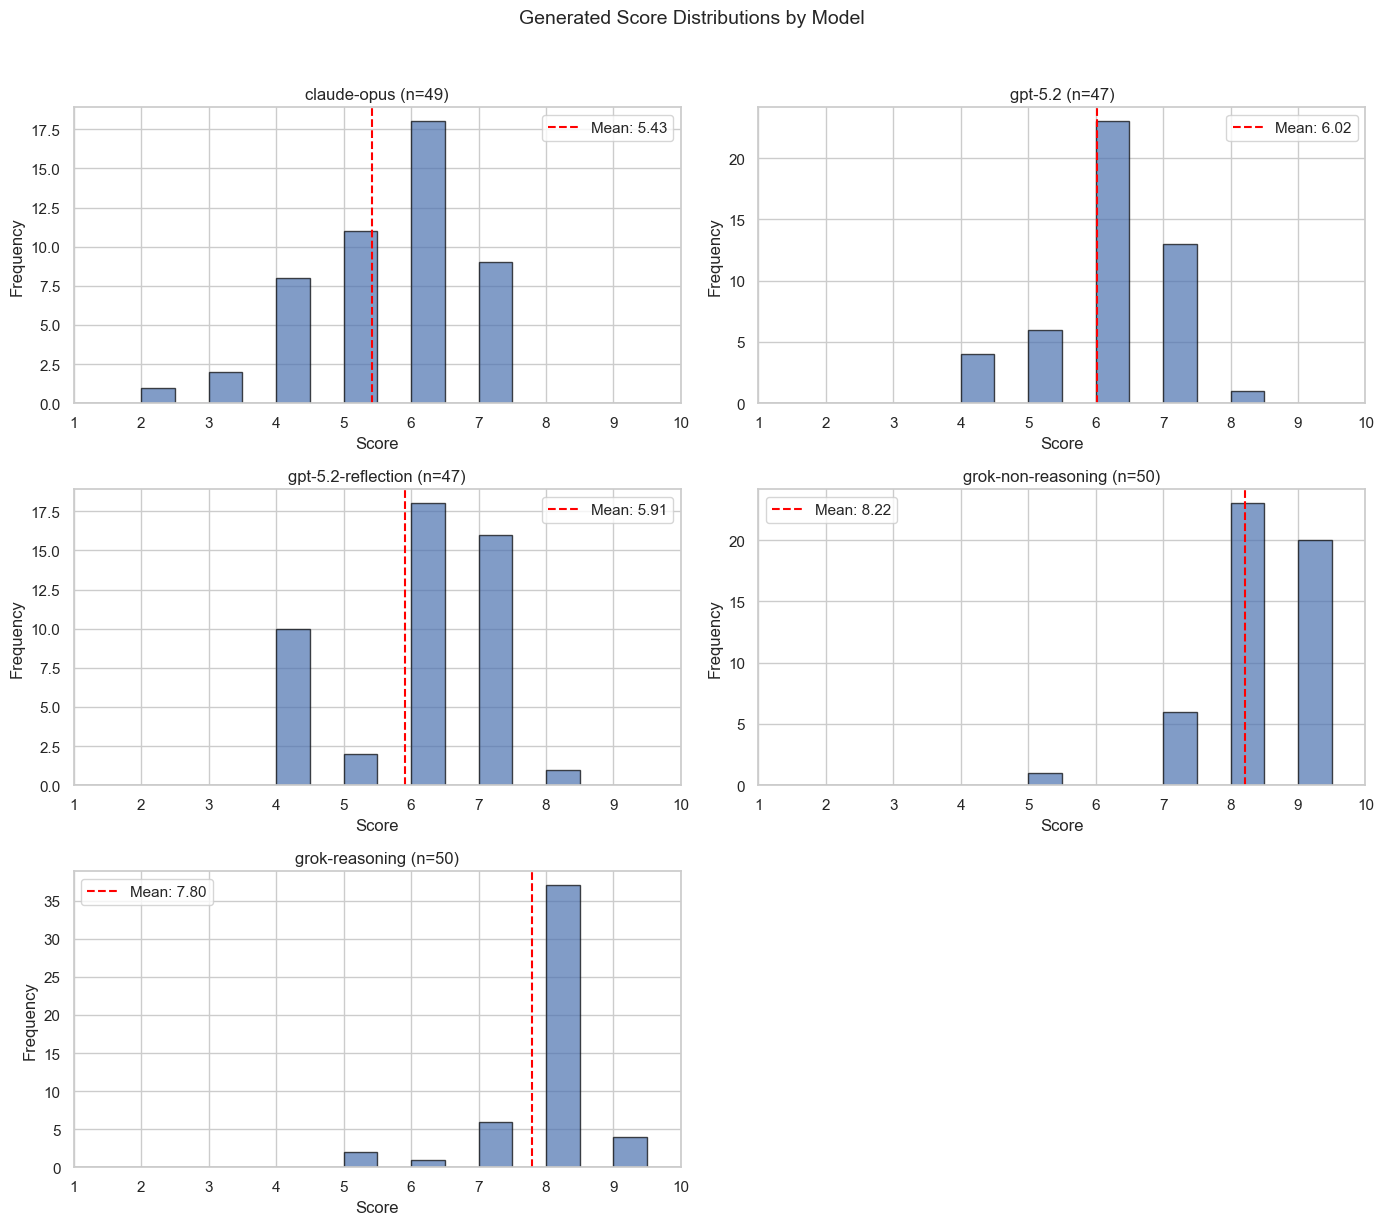

In [5]:
# Generated score distributions by model
configs = sorted(df["config"].unique())
n_configs = len(configs)
n_cols = 2
n_rows = (n_configs + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for idx, config_name in enumerate(configs):
    ax = axes[idx]
    config_df = df[df["config"] == config_name]
    scores = config_df[config_df["generated_score"] > 0]["generated_score"]
    
    ax.hist(scores, bins=np.arange(1, 11, 0.5), edgecolor="black", alpha=0.7)
    ax.axvline(scores.mean(), color="red", linestyle="--", label=f"Mean: {scores.mean():.2f}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{config_name} (n={len(scores)})")
    ax.legend()
    ax.set_xlim(1, 10)

# Hide unused axes
for idx in range(n_configs, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle("Generated Score Distributions by Model", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../data_50/benchmark_results/score_distributions_by_model.png", dpi=150, bbox_inches="tight")
plt.show()

## Real vs Generated Score Scatter Plots

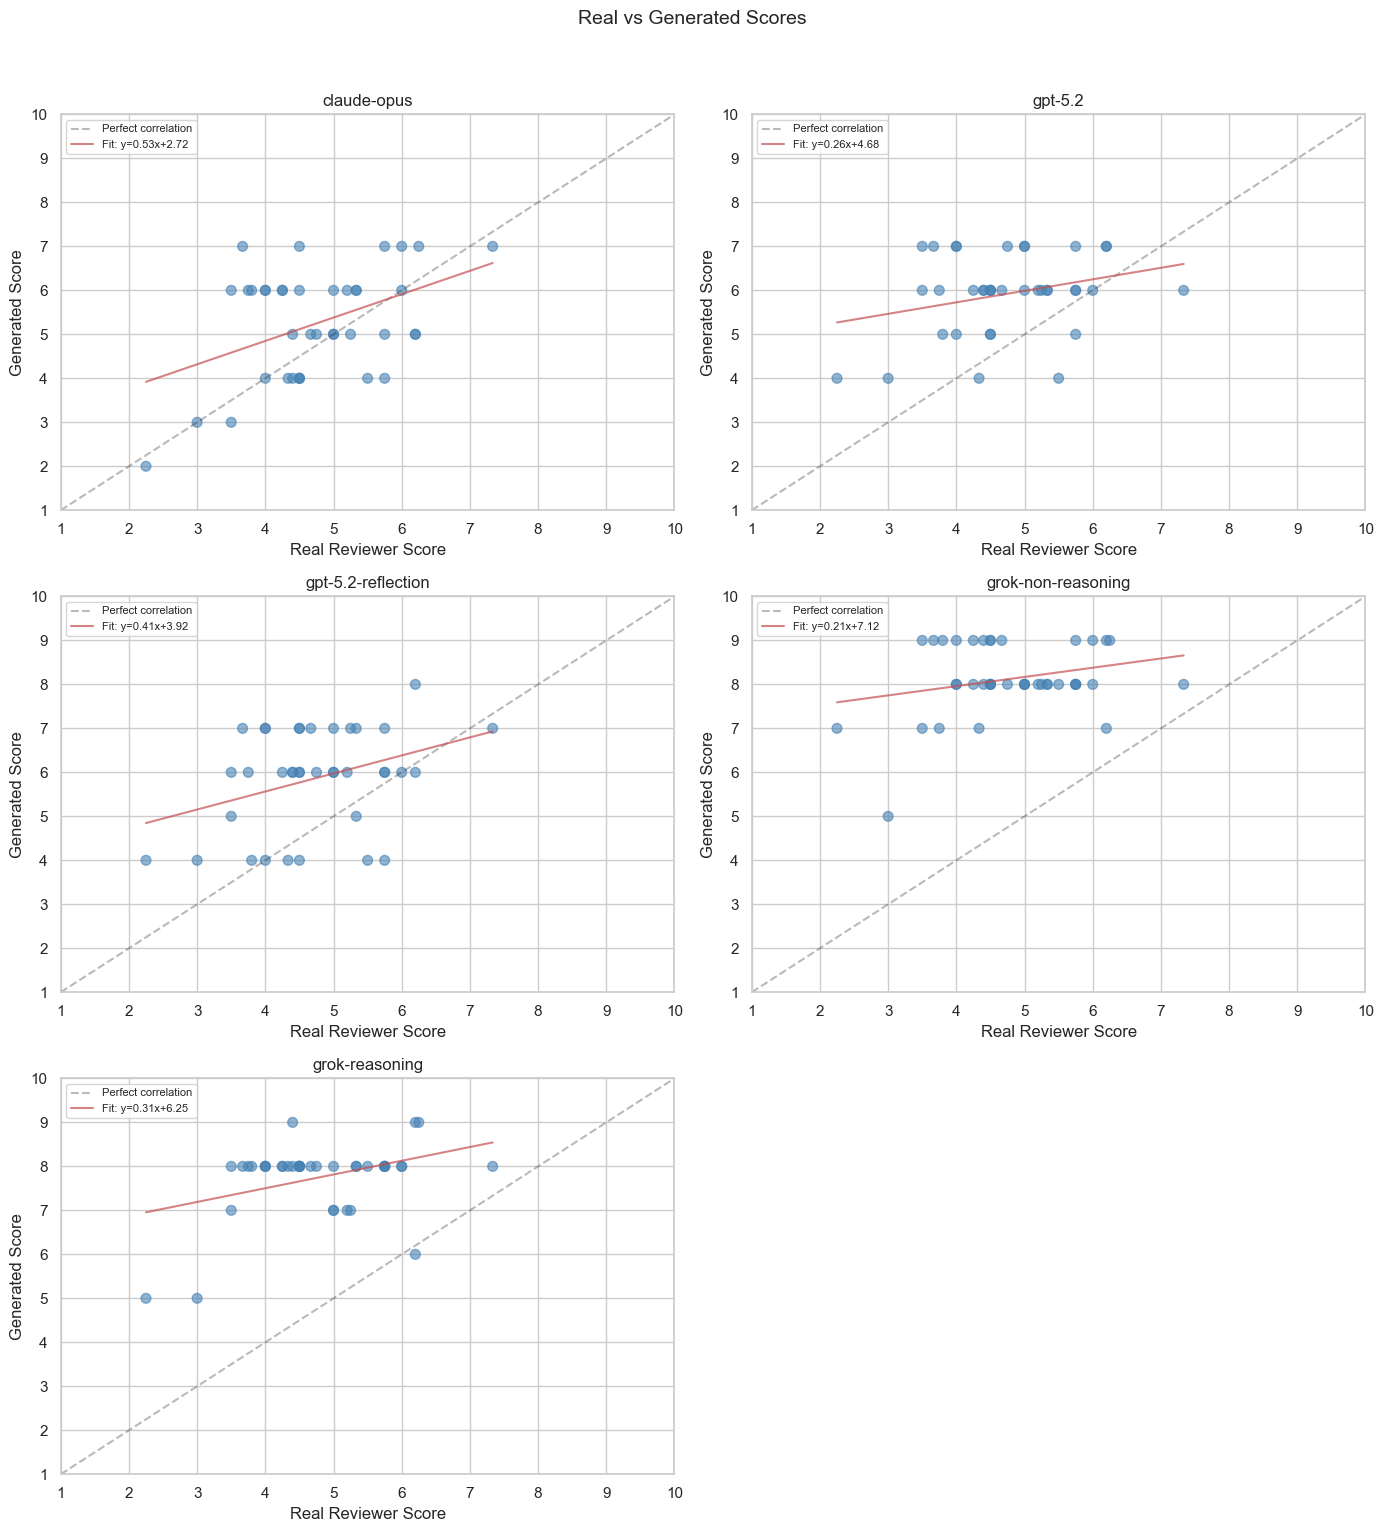

In [6]:
# Scatter plot: real vs generated scores by model
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

for idx, config_name in enumerate(configs):
    ax = axes[idx]
    config_df = df[(df["config"] == config_name) & (df["real_score"] > 0) & (df["generated_score"] > 0)]
    
    # Color by sample category
    colors = config_df["sample_category"].map({"random": "steelblue", "top_tier": "coral"})
    
    ax.scatter(config_df["real_score"], config_df["generated_score"], c=colors, alpha=0.6, s=50)
    
    # Add diagonal line (perfect correlation)
    ax.plot([1, 10], [1, 10], "k--", alpha=0.3, label="Perfect correlation")
    
    # Add regression line
    if len(config_df) > 2:
        z = np.polyfit(config_df["real_score"], config_df["generated_score"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(config_df["real_score"].min(), config_df["real_score"].max(), 100)
        ax.plot(x_line, p(x_line), "r-", alpha=0.7, label=f"Fit: y={z[0]:.2f}x+{z[1]:.2f}")
    
    ax.set_xlabel("Real Reviewer Score")
    ax.set_ylabel("Generated Score")
    ax.set_title(f"{config_name}")
    ax.legend(loc="upper left", fontsize=8)
    ax.set_xlim(1, 10)
    ax.set_ylim(1, 10)

# Hide unused axes
for idx in range(n_configs, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle("Real vs Generated Scores", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../data_50/benchmark_results/real_vs_generated_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

## Metrics Comparison

In [7]:
# Load metrics from results
metrics_rows = []
for config_name, data in results.items():
    metrics = data.get("metrics")
    config = data.get("config", {})
    
    # Skip configs without computed metrics (still running)
    if metrics is None:
        print(f"Skipping {config_name}: metrics not yet computed (benchmark may still be running)")
        continue
        
    metrics_rows.append({
        "config": config_name,
        "model": config.get("model", "unknown"),
        "reflections": config.get("num_reflections", 0),
        "spearman_rho": metrics.get("spearman_rho_full", 0),
        "auc_roc": metrics.get("auc_roc", 0.5),
        "accuracy": metrics.get("accuracy", 0),
        "precision": metrics.get("precision", 0),
        "recall": metrics.get("recall", 0),
        "f1_score": metrics.get("f1_score", 0),
        "cohens_d": metrics.get("cohens_d", 0),
        "n_total": metrics.get("n_total", 0),
    })

metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.sort_values("spearman_rho", ascending=False)
metrics_df

,config,model,reflections,spearman_rho,auc_roc,accuracy,precision,recall,f1_score,cohens_d,n_total
3,gpt-5.2-reflection,openai:gpt-5.2,1,0.283308,0.613911,0.468085,0.371429,0.812500,0.509804,0.358362,47
2,claude-opus,anthropic:claude-opus-4-6,0,0.271015,0.801075,0.693878,0.555556,0.833333,0.666667,1.191742,49
0,grok-reasoning,xai:grok-4-1-fast-reasoning,0,0.219040,0.647569,0.420000,0.382979,1.000000,0.553846,0.644840,50
1,gpt-5.2,openai:gpt-5.2,0,0.192311,0.608871,0.510638,0.400000,0.875000,0.549020,0.487450,47
4,grok-non-reasoning,xai:grok-4-1-fast-non-reasoning,0,0.122323,0.682292,0.380000,0.367347,1.000000,0.537313,0.669783,50


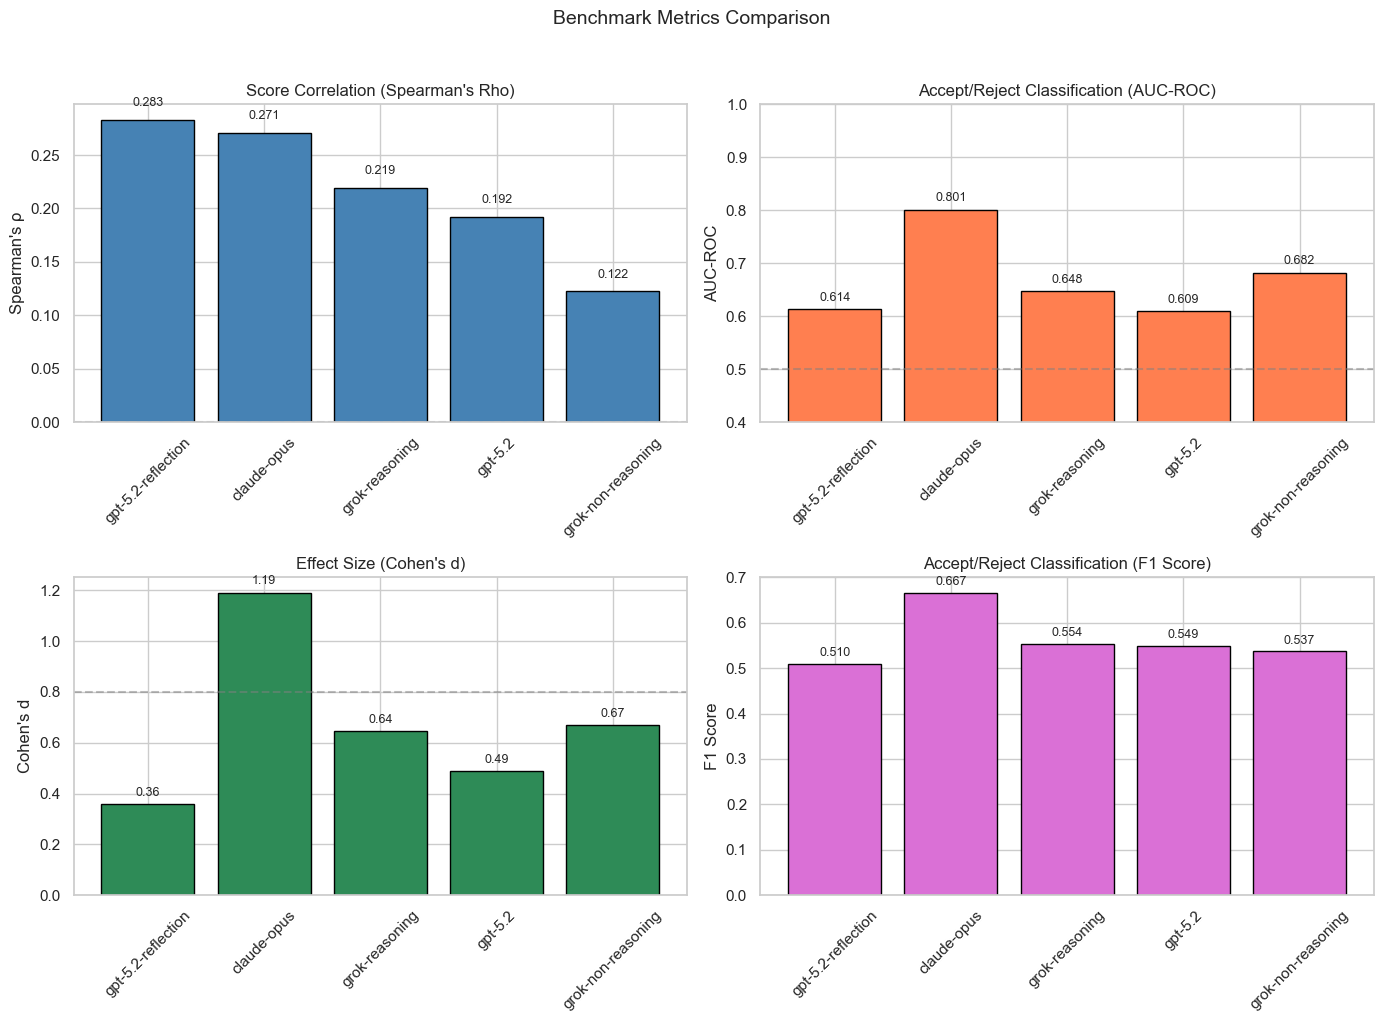

In [8]:
# Bar chart comparison of key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Spearman's Rho
ax1 = axes[0, 0]
bars = ax1.bar(metrics_df["config"], metrics_df["spearman_rho"], color="steelblue", edgecolor="black")
ax1.set_ylabel("Spearman's ρ")
ax1.set_title("Score Correlation (Spearman's Rho)")
ax1.tick_params(axis="x", rotation=45)
ax1.axhline(0, color="gray", linestyle="--", alpha=0.5)
for bar, val in zip(bars, metrics_df["spearman_rho"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.3f}", 
             ha="center", va="bottom", fontsize=9)

# AUC-ROC
ax2 = axes[0, 1]
bars = ax2.bar(metrics_df["config"], metrics_df["auc_roc"], color="coral", edgecolor="black")
ax2.set_ylabel("AUC-ROC")
ax2.set_title("Accept/Reject Classification (AUC-ROC)")
ax2.tick_params(axis="x", rotation=45)
ax2.axhline(0.5, color="gray", linestyle="--", alpha=0.5, label="Random baseline")
ax2.set_ylim(0.4, 1.0)
for bar, val in zip(bars, metrics_df["auc_roc"]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.3f}", 
             ha="center", va="bottom", fontsize=9)

# Cohen's d
ax3 = axes[1, 0]
bars = ax3.bar(metrics_df["config"], metrics_df["cohens_d"], color="seagreen", edgecolor="black")
ax3.set_ylabel("Cohen's d")
ax3.set_title("Effect Size (Cohen's d)")
ax3.tick_params(axis="x", rotation=45)
ax3.axhline(0.8, color="gray", linestyle="--", alpha=0.5, label="Large effect")
for bar, val in zip(bars, metrics_df["cohens_d"]):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{val:.2f}", 
             ha="center", va="bottom", fontsize=9)

# F1 Score
ax4 = axes[1, 1]
bars = ax4.bar(metrics_df["config"], metrics_df["f1_score"], color="orchid", edgecolor="black")
ax4.set_ylabel("F1 Score")
ax4.set_title("Accept/Reject Classification (F1 Score)")
ax4.tick_params(axis="x", rotation=45)
for bar, val in zip(bars, metrics_df["f1_score"]):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{val:.3f}", 
             ha="center", va="bottom", fontsize=9)

plt.suptitle("Benchmark Metrics Comparison", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../data_50/benchmark_results/metrics_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## Confusion Matrices

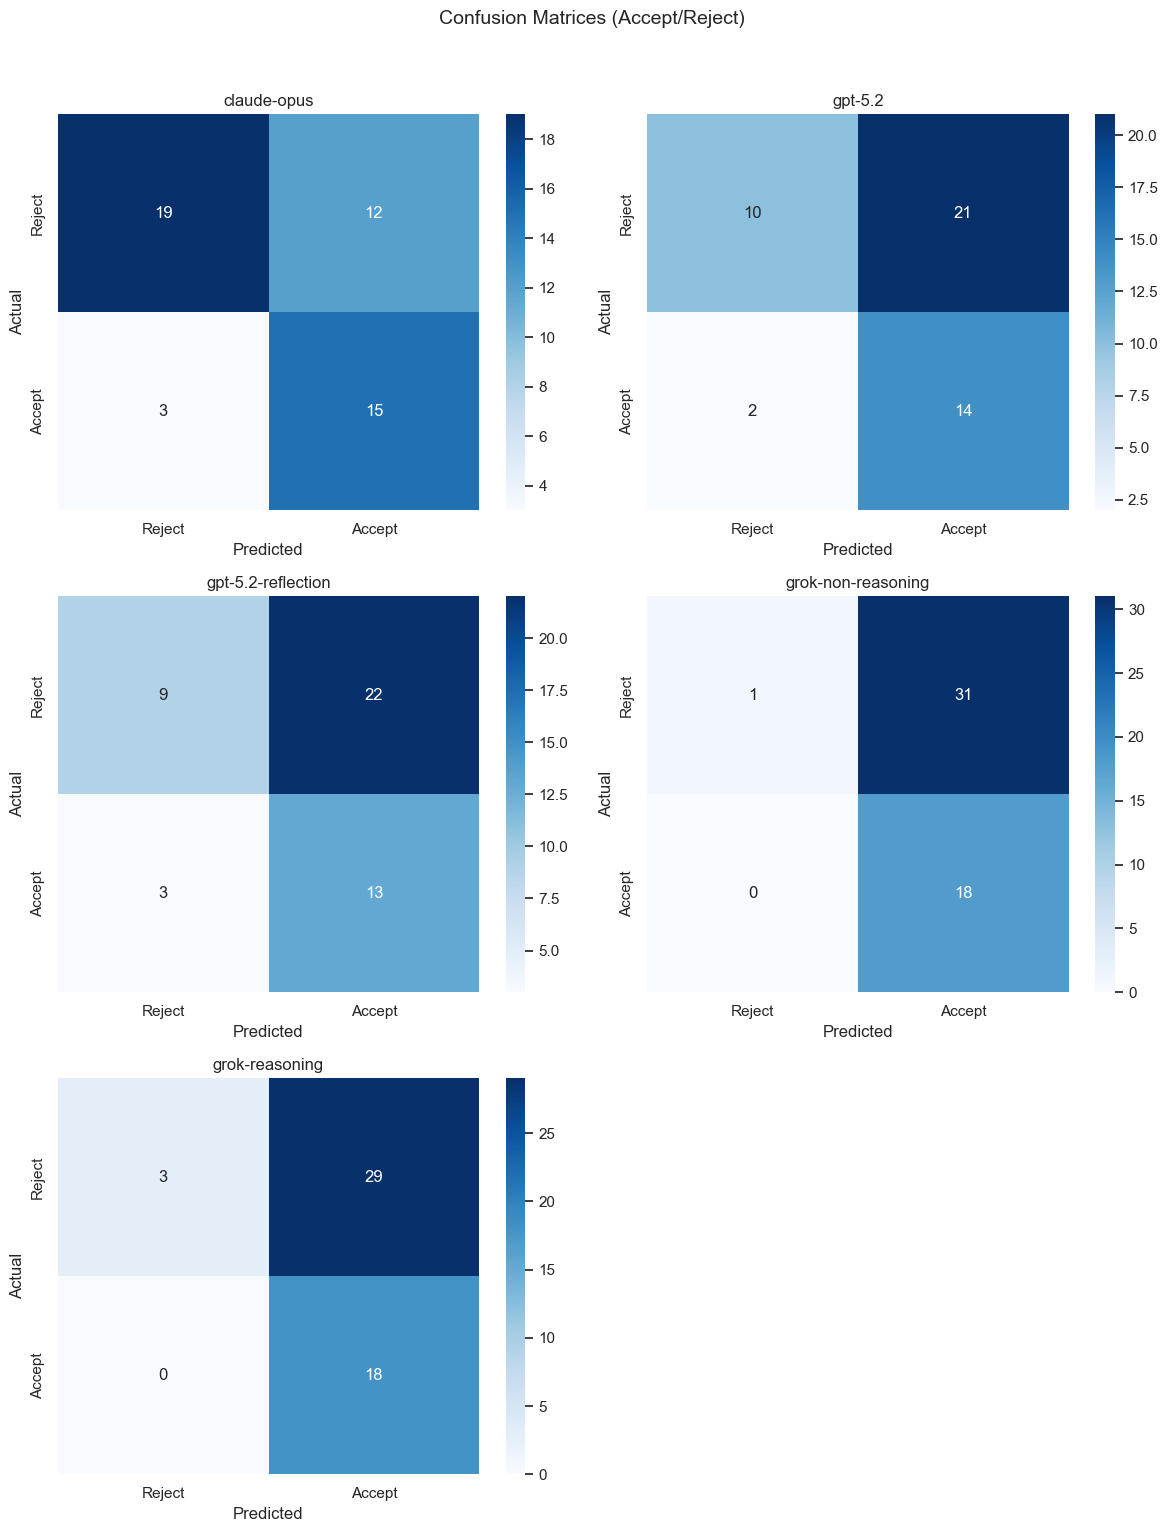

In [9]:
from sklearn.metrics import confusion_matrix

def is_accepted(decision: str) -> bool:
    """Check if a decision string indicates acceptance."""
    decision_lower = decision.lower()
    return "accept" in decision_lower and "reject" not in decision_lower

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for idx, config_name in enumerate(configs):
    ax = axes[idx]
    config_df = df[df["config"] == config_name]
    
    y_true = [1 if is_accepted(d) else 0 for d in config_df["real_decision"]]
    y_pred = [1 if is_accepted(d) else 0 for d in config_df["generated_decision"]]
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["Reject", "Accept"], yticklabels=["Reject", "Accept"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{config_name}")

# Hide unused axes
for idx in range(n_configs, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle("Confusion Matrices (Accept/Reject)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../data_50/benchmark_results/confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

## Score Differences by Conference

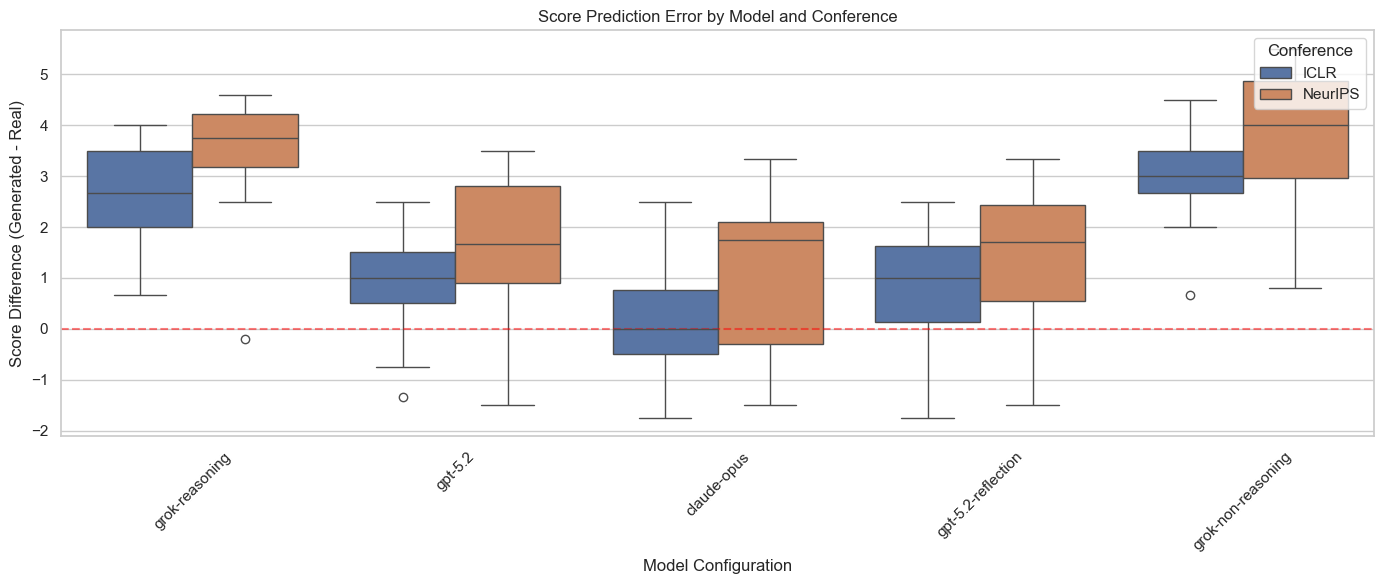

In [10]:
# Box plot of score differences by conference
df_valid = df[(df["real_score"] > 0) & (df["generated_score"] > 0)].copy()
df_valid["score_diff"] = df_valid["generated_score"] - df_valid["real_score"]

fig, ax = plt.subplots(figsize=(14, 6))

# Create box plot grouped by config and conference
df_valid["group"] = df_valid["config"] + " (" + df_valid["conference"] + ")"
order = sorted(df_valid["group"].unique())

sns.boxplot(data=df_valid, x="config", y="score_diff", hue="conference", ax=ax)
ax.axhline(0, color="red", linestyle="--", alpha=0.5)
ax.set_xlabel("Model Configuration")
ax.set_ylabel("Score Difference (Generated - Real)")
ax.set_title("Score Prediction Error by Model and Conference")
ax.tick_params(axis="x", rotation=45)
ax.legend(title="Conference", loc="upper right")

plt.tight_layout()
plt.savefig("../data_50/benchmark_results/score_diff_by_conference.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary Table

In [11]:
# Create a formatted summary table
summary = metrics_df[["config", "model", "reflections", "n_total", "spearman_rho", "auc_roc", "f1_score", "cohens_d"]].copy()
summary.columns = ["Config", "Model", "Reflections", "N Papers", "Spearman ρ", "AUC-ROC", "F1", "Cohen's d"]

# Format numeric columns
for col in ["Spearman ρ", "AUC-ROC", "F1", "Cohen's d"]:
    summary[col] = summary[col].apply(lambda x: f"{x:.3f}")

summary.style.set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
])

,Config,Model,Reflections,N Papers,Spearman ρ,AUC-ROC,F1,Cohen's d
3,gpt-5.2-reflection,openai:gpt-5.2,1,47,0.283,0.614,0.510,0.358
2,claude-opus,anthropic:claude-opus-4-6,0,49,0.271,0.801,0.667,1.192
0,grok-reasoning,xai:grok-4-1-fast-reasoning,0,50,0.219,0.648,0.554,0.645
1,gpt-5.2,openai:gpt-5.2,0,47,0.192,0.609,0.549,0.487
4,grok-non-reasoning,xai:grok-4-1-fast-non-reasoning,0,50,0.122,0.682,0.537,0.670
